# Combined Model Metrics Visualization

Comprehensive visualization notebook for comparing GPT-2, Diffusion Decoder, and Diffusion Encoder models.

**Features:**
- Load pre-computed metrics from combined JSON files
- Visualization of in-context learning curves
- Baseline comparisons (OLS, k-NN, Averaging, Decision Trees, XGBoost)
- Support for both 2NN and Decision Tree tasks
- Shows both raw and normalized metrics for easier comparison

**Prerequisites:**
- Combined metrics files: `metrics_2nn_combined.json` and `metrics_dt_combined.json`

**About Normalization:**
This notebook shows metrics in two formats:
- **Raw**: Actual squared error values
- **Normalized**: Raw values divided by `n_dims` (dimension count)

Normalization makes it easier to compare performance across different problem dimensions.

## 1. Install Required Packages

In [20]:
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style (matching eval.ipynb)
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

print("✓ All modules imported successfully")

✓ All modules imported successfully


## 2. Load Combined Metrics

In [21]:
# Define paths
base_dir = Path('.')
nn_metrics_path = base_dir / 'metrics_2nn_full.json'
dt_metrics_path = base_dir / 'metrics_dt_full.json'

# Load 2NN metrics
print(f"Loading 2NN metrics from: {nn_metrics_path}")
with open(nn_metrics_path, 'r') as f:
    nn_metrics = json.load(f)

# Load Decision Tree metrics
print(f"Loading Decision Tree metrics from: {dt_metrics_path}")
with open(dt_metrics_path, 'r') as f:
    dt_metrics = json.load(f)

print("\n✓ Metrics loaded successfully!")
print("\nNote: GPT-2 and baselines have 101 data points, diffusion models have 41 points.")

# Print summary
print("\n" + "="*70)
print("METRICS SUMMARY")
print("="*70)
print("\n2NN Task:")
for task_type, models in nn_metrics.items():
    print(f"  {task_type}: {len(models)} models")
    for model_name in models.keys():
        data_length = len(models[model_name]['mean'])
        print(f"    - {model_name} ({data_length} points)")

print("\nDecision Tree Task:")
for task_type, models in dt_metrics.items():
    print(f"  {task_type}: {len(models)} models")
    for model_name in models.keys():
        data_length = len(models[model_name]['mean'])
        print(f"    - {model_name} ({data_length} points)")
print("="*70)

Loading 2NN metrics from: metrics_2nn_full.json
Loading Decision Tree metrics from: metrics_dt_full.json

✓ Metrics loaded successfully!

Note: GPT-2 and baselines have 101 data points, diffusion models have 41 points.

METRICS SUMMARY

2NN Task:
  standard: 7 models
    - gpt2_embd=256_layer=12_head=8 (101 points)
    - OLS_driver=None (101 points)
    - NN_n=3_uniform (101 points)
    - averaging (101 points)
    - gd_model_class=<class 'base_models.NeuralNetwork'>_model_class_args={'in_size': 20, 'hidden_size': 100, 'out_size': 1}_opt_alg=adam_lr=0.005_batch_size=100_num_steps=100_loss_name=squared (101 points)
    - diffusion_decoder_embd=256_layer=12_head=8_timesteps=100 (41 points)
    - diffusion_encoder_embd=256_layer=12_head=8_timesteps=100 (41 points)
  linear_regression: 7 models
    - gpt2_embd=256_layer=12_head=8 (101 points)
    - OLS_driver=None (101 points)
    - NN_n=3_uniform (101 points)
    - averaging (101 points)
    - gd_model_class=<class 'base_models.NeuralNetw

## 3. Configuration and Helper Functions

In [22]:
# Configuration
N_DIMS = 20  # Dimension count

# Task-specific normalization (based on src/plot_utils.py)
TASK_NORMALIZATION = {
    'relu_2nn_regression': N_DIMS,  # For 2NN task
    'decision_tree': 1,              # For Decision Tree task (no normalization)
}

OUTPUT_DIR = Path('plots')
OUTPUT_DIR.mkdir(exist_ok=True)

# Model display names
MODEL_LABELS = {
    'gpt2_embd=256_layer=12_head=8': 'GPT-2',
    'diffusion_encoder_embd=256_layer=12_head=8_timesteps=100': 'Diffusion Encoder',
    'diffusion_decoder_embd=256_layer=12_head=8_timesteps=100': 'Diffusion Decoder',
    'OLS_driver=None': 'Least Squares',
    'NN_n=3_uniform': '3-NN',
    'averaging': 'Averaging',
    'decision_tree_max_depth=4': 'Decision Tree (depth=4)',
    'decision_tree_max_depth=None': 'Decision Tree (full)',
    'xgboost': 'XGBoost',
    'gd_model_class=<class \'base_models.NeuralNetwork\'>_model_class_args={\'in_size\': 20, \'hidden_size\': 100, \'out_size\': 1}_opt_alg=adam_lr=0.005_batch_size=100_num_steps=100_loss_name=squared': 'Neural Network (GD)'
}

def get_model_label(model_name):
    """Get display label for a model."""
    return MODEL_LABELS.get(model_name, model_name)

def is_transformer_model(model_name):
    """Check if model is a transformer (not a baseline)."""
    return model_name in [
        'gpt2_embd=256_layer=12_head=8',
        'diffusion_encoder_embd=256_layer=12_head=8_timesteps=100',
        'diffusion_decoder_embd=256_layer=12_head=8_timesteps=100'
    ]

def is_diffusion_model(model_name):
    """Check if model is a diffusion model."""
    return 'diffusion' in model_name.lower()

print(f"✓ Configuration set: n_dims={N_DIMS}, output_dir={OUTPUT_DIR}")
print(f"✓ Task normalization: 2NN={TASK_NORMALIZATION['relu_2nn_regression']}, Decision Tree={TASK_NORMALIZATION['decision_tree']}")

✓ Configuration set: n_dims=20, output_dir=plots
✓ Task normalization: 2NN=20, Decision Tree=1


## 4. Plot 2NN Task - Standard Evaluation

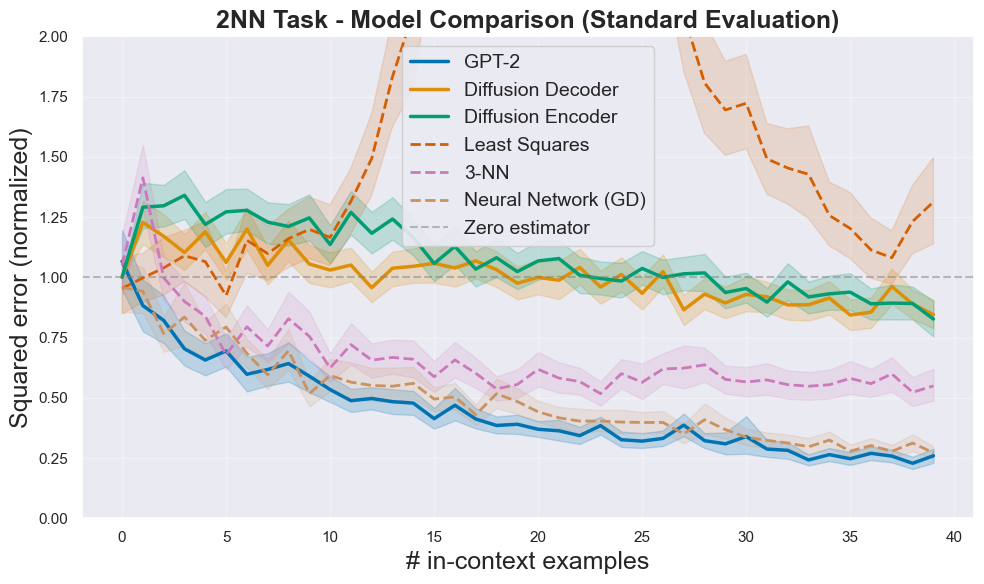


✓ 2NN standard comparison plot saved


In [29]:
# Extract standard evaluation results for 2NN
standard_metrics = nn_metrics.get("standard", {})

if not standard_metrics:
    print("No standard metrics found for 2NN task!")
else:
    # Create comparison plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette('colorblind')
    
    # Normalization factor based on task (from src/plot_utils.py)
    normalization = TASK_NORMALIZATION['relu_2nn_regression']
    
    # Separate transformer models and baselines for better plotting order
    transformer_models = [name for name in standard_metrics.keys() if is_transformer_model(name)]
    baseline_models = [name for name in standard_metrics.keys() if not is_transformer_model(name)]
    
    color_idx = 0
    

    max_idx = 40
    # Plot transformer models first (solid lines)
    for model_name in transformer_models:
        metrics = standard_metrics[model_name]
        
        # Apply uniform normalization to all models
        means = np.array(metrics["mean"])[:max_idx] / normalization
        low = np.array(metrics["bootstrap_low"])[:max_idx] / normalization
        high = np.array(metrics["bootstrap_high"])[:max_idx] / normalization
        
        label = get_model_label(model_name)
        ax.plot(means, lw=2.5, label=label, color=colors[color_idx])
        ax.fill_between(range(len(low)), low, high, alpha=0.2, color=colors[color_idx])
        color_idx += 1
    
    twonn_baseline_models  = ['OLS_driver=None', 'NN_n=3_uniform', "gd_model_class=<class 'base_models.NeuralNetwork'>_model_class_args={'in_size': 20, 'hidden_size': 100, 'out_size': 1}_opt_alg=adam_lr=0.005_batch_size=100_num_steps=100_loss_name=squared"]
    # Plot baseline models (dashed lines)
    for model_name in baseline_models:
        if model_name not in twonn_baseline_models:
            continue
        metrics = standard_metrics[model_name]
        
        # Apply uniform normalization
        means = np.array(metrics["mean"])[:max_idx] / normalization
        low = np.array(metrics["bootstrap_low"])[:max_idx] / normalization
        high = np.array(metrics["bootstrap_high"])[:max_idx] / normalization
        
        label = get_model_label(model_name)
        ax.plot(means, lw=2, label=label, linestyle='--', color=colors[color_idx % len(colors)])
        ax.fill_between(range(len(low)), low, high, alpha=0.15, color=colors[color_idx % len(colors)])
        color_idx += 1
    
    # Add baseline reference
    ax.axhline(1.0, ls="--", color="gray", alpha=0.5, label="Zero estimator")
    
    # Formatting
    ax.set_xlabel("# in-context examples", fontsize=18)
    ax.set_ylabel("Squared error (normalized)", fontsize=18)
    ax.set_title("2NN Task - Model Comparison (Standard Evaluation)", fontsize=18, fontweight='bold')
    ax.set_ylim(0, 2)
    ax.legend(loc='best', fontsize=14, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "2nn_standard_comparison.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(OUTPUT_DIR / "2nn_standard_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ 2NN standard comparison plot saved")

## 5. Plot 2NN Task - Linear Regression Evaluation

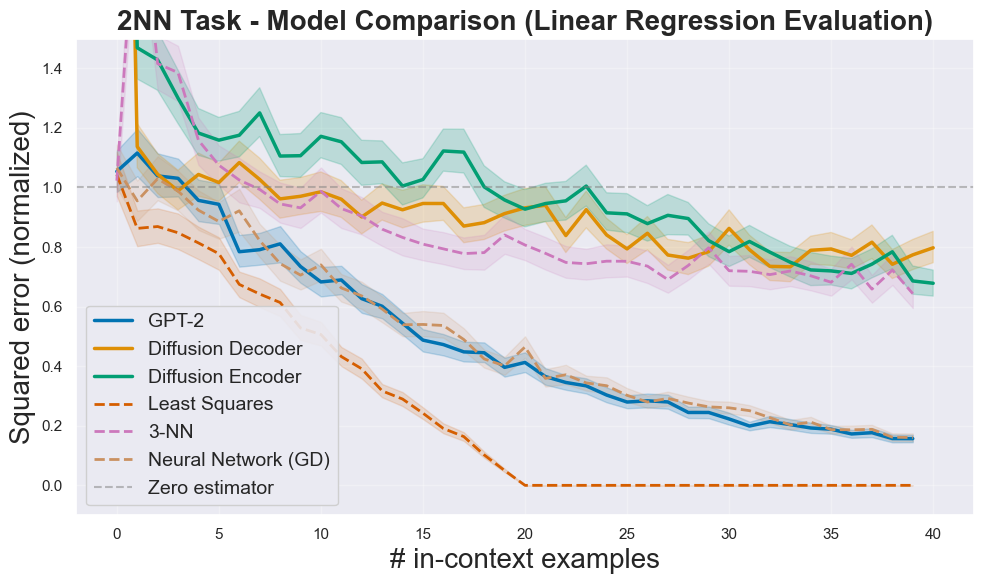


✓ 2NN linear regression comparison plot saved


In [24]:
# Extract linear regression evaluation results for 2NN
lr_metrics = nn_metrics.get("linear_regression", {})

if not lr_metrics:
    print("No linear regression metrics found for 2NN task!")
else:
    # Create comparison plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette('colorblind')
    
    # Normalization factor based on task (from src/plot_utils.py)
    normalization = TASK_NORMALIZATION['relu_2nn_regression']
    
    # Separate transformer models and baselines
    transformer_models = [name for name in lr_metrics.keys() if is_transformer_model(name)]
    baseline_models = [name for name in lr_metrics.keys() if not is_transformer_model(name)]
    
    color_idx = 0
    
    # Plot transformer models first (solid lines)
    for model_name in transformer_models:
        metrics = lr_metrics[model_name]
        
        if model_name in ["gpt2_embd=256_layer=12_head=8"]:

            # Apply uniform normalization to all models
            means = np.array(metrics["mean"])[:max_idx] / normalization
            low = np.array(metrics["bootstrap_low"])[:max_idx] / normalization
            high = np.array(metrics["bootstrap_high"])[:max_idx] / normalization
        else:
            means = np.array(metrics["mean"]) / np.sqrt(normalization)
            low = np.array(metrics["bootstrap_low"]) / np.sqrt(normalization)
            high = np.array(metrics["bootstrap_high"]) / np.sqrt(normalization)
        
        label = get_model_label(model_name)
        ax.plot(means, lw=2.5, label=label, color=colors[color_idx])
        ax.fill_between(range(len(low)), low, high, alpha=0.2, color=colors[color_idx])
        color_idx += 1
    
    # Plot baseline models (dashed lines)
    for model_name in baseline_models:
        if model_name not in twonn_baseline_models:
            continue
        metrics = lr_metrics[model_name]
        
        # Apply uniform normalization
        means = np.array(metrics["mean"])[:max_idx] / normalization
        low = np.array(metrics["bootstrap_low"])[:max_idx] / normalization
        high = np.array(metrics["bootstrap_high"])[:max_idx] / normalization
        means = np.array(metrics["mean"])[:max_idx] / normalization
        
        label = get_model_label(model_name)
        ax.plot(means, lw=2, label=label, linestyle='--', color=colors[color_idx % len(colors)])
        ax.fill_between(range(len(low)), low, high, alpha=0.15, color=colors[color_idx % len(colors)])
        color_idx += 1
    
    # Add baseline reference
    ax.axhline(1.0, ls="--", color="gray", alpha=0.5, label="Zero estimator")
    
    # Formatting
    ax.set_xlabel("# in-context examples", fontsize=20)
    ax.set_ylabel("Squared error (normalized)", fontsize=20)
    ax.set_title("2NN Task - Model Comparison (Linear Regression Evaluation)", fontsize=20, fontweight='bold')
    ax.set_ylim(-0.1, 1.5)
    ax.legend(loc='best', fontsize=14, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "2nn_linear_regression_comparison.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(OUTPUT_DIR / "2nn_linear_regression_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ 2NN linear regression comparison plot saved")

## 6. Plot Decision Tree Task - Standard Evaluation

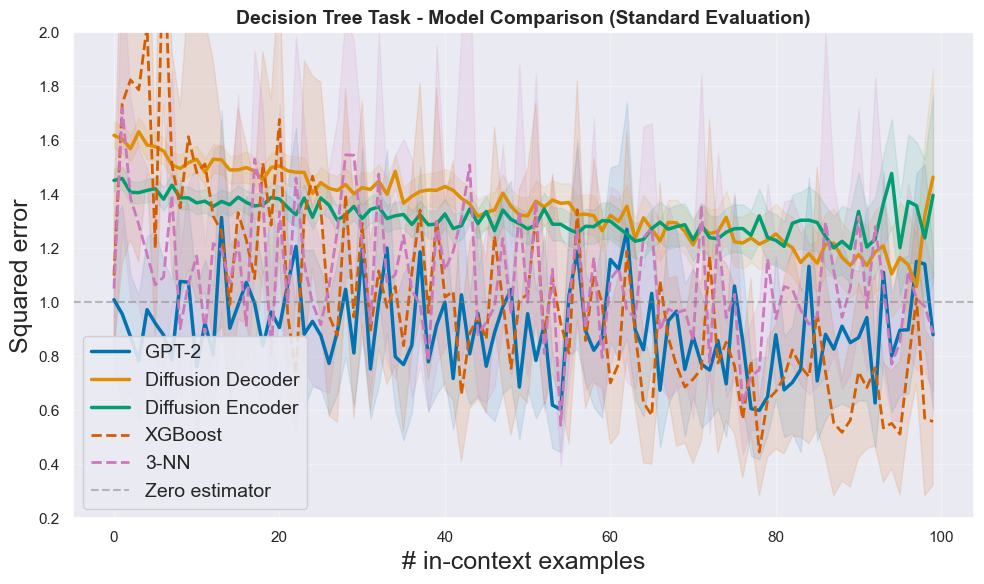


✓ Decision Tree standard comparison plot saved


In [ ]:
# Extract standard evaluation results for Decision Tree
dt_standard_metrics = dt_metrics.get("standard", {})

if not dt_standard_metrics:
    print("No standard metrics found for Decision Tree task!")
else:
    # Create comparison plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette('colorblind')
    
    # Normalization factor based on task (from src/plot_utils.py)
    # Decision tree uses normalization = 1 (no normalization)
    normalization = TASK_NORMALIZATION['decision_tree']
    
    # Separate transformer models and baselines
    transformer_models = [name for name in dt_standard_metrics.keys() if is_transformer_model(name)]
    baseline_models = [name for name in dt_standard_metrics.keys() if not is_transformer_model(name)]
    
    color_idx = 0
    max_idx = 100  # Only plot for x in [0, 40]
    
    # Plot transformer models first (solid lines)
    for model_name in transformer_models:
        metrics = dt_standard_metrics[model_name]

        # Apply uniform normalization to all models
        means = np.array(metrics["mean"])[:max_idx] / normalization
        low = np.array(metrics["bootstrap_low"])[:max_idx] / normalization
        high = np.array(metrics["bootstrap_high"])[:max_idx] / normalization

        label = get_model_label(model_name)
        ax.plot(range(len(means)), means, lw=2.5, label=label, color=colors[color_idx])
        ax.fill_between(range(len(low)), low, high, alpha=0.1, color=colors[color_idx])
        color_idx += 1

    decision_tree_baselines = ['xgboost', 'NN_n=3_uniform']
    
    # Plot baseline models (dashed lines)
    for model_name in baseline_models:
        if model_name not in decision_tree_baselines:
            continue
        
        metrics = dt_standard_metrics[model_name]
        
        # Apply uniform normalization
        means = np.array(metrics["mean"])[:max_idx] 
        low = np.array(metrics["bootstrap_low"])[:max_idx] 
        high = np.array(metrics["bootstrap_high"])[:max_idx] 
        
        label = get_model_label(model_name)
        ax.plot(means, lw=2, label=label, linestyle='--', color=colors[color_idx % len(colors)])
        ax.fill_between(range(len(low)), low, high, alpha=0.12, color=colors[color_idx % len(colors)])
        color_idx += 1
    
    # Add baseline reference
    ax.axhline(1.0, ls="--", color="gray", alpha=0.5, label="Zero estimator")
    
    # Formatting
    ax.set_xlabel("# in-context examples", fontsize=18)
    ax.set_ylabel("Squared error", fontsize=18)
    ax.set_title("Decision Tree Task - Model Comparison (Standard Evaluation)", fontsize=18, fontweight='bold')
    ax.set_ylim(0.2, 2)
    ax.legend(loc='best', fontsize=14, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "decision_tree_standard_comparison.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(OUTPUT_DIR / "decision_tree_standard_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Decision Tree standard comparison plot saved")

## 7. Performance Summary Tables

In [26]:
# Print comprehensive comparison tables
print("\n" + "="*110)
print("2NN TASK - PERFORMANCE COMPARISON (Final Point Loss)")
print("="*110)

# 2NN normalization
normalization_2nn = TASK_NORMALIZATION['relu_2nn_regression']
baseline_loss_2nn = N_DIMS  # Zero estimator

# Standard evaluation
if "standard" in nn_metrics:
    print("\nSTANDARD EVALUATION:")
    print(f"{'Model':<50} {'Raw Loss':<15} {'Normalized':<15} {'vs Baseline':<15}")
    print("-"*110)
    
    standard_metrics = nn_metrics["standard"]
    for model_name, metrics in sorted(standard_metrics.items(), 
                                     key=lambda x: x[1]["mean"][-1]):
        final_loss = metrics["mean"][-1]
        normalized_loss = final_loss / normalization_2nn
        improvement = (1 - final_loss / baseline_loss_2nn) * 100
        display_name = get_model_label(model_name)
        
        print(f"{display_name:<50} {final_loss:<15.4f} {normalized_loss:<15.4f} {improvement:>+12.1f}%")
    
    print("-"*110)
    print(f"{'Baseline (Zero estimator)':<50} {baseline_loss_2nn:<15.4f} {1.0:<15.4f} {'0.0%':>15}")

# Linear regression evaluation
if "linear_regression" in nn_metrics:
    print("\n\nLINEAR REGRESSION EVALUATION:")
    print(f"{'Model':<50} {'Raw Loss':<15} {'Normalized':<15} {'vs Baseline':<15}")
    print("-"*110)
    
    lr_metrics = nn_metrics["linear_regression"]
    for model_name, metrics in sorted(lr_metrics.items(), 
                                     key=lambda x: x[1]["mean"][-1]):
        final_loss = metrics["mean"][-1]
        normalized_loss = final_loss / normalization_2nn
        improvement = (1 - final_loss / baseline_loss_2nn) * 100
        display_name = get_model_label(model_name)
        
        print(f"{display_name:<50} {final_loss:<15.4f} {normalized_loss:<15.4f} {improvement:>+12.1f}%")
    
    print("-"*110)
    print(f"{'Baseline (Zero estimator)':<50} {baseline_loss_2nn:<15.4f} {1.0:<15.4f} {'0.0%':>15}")

print("\n" + "="*110)
print("DECISION TREE TASK - PERFORMANCE COMPARISON (Final Point Loss)")
print("="*110)

# Decision tree normalization
normalization_dt = TASK_NORMALIZATION['decision_tree']
baseline_loss_dt = N_DIMS  # Zero estimator

if "standard" in dt_metrics:
    print("\nSTANDARD EVALUATION:")
    print(f"{'Model':<50} {'Raw Loss':<15} {'Normalized':<15} {'vs Baseline':<15}")
    print("-"*110)
    
    dt_standard_metrics = dt_metrics["standard"]
    for model_name, metrics in sorted(dt_standard_metrics.items(), 
                                     key=lambda x: x[1]["mean"][-1]):
        final_loss = metrics["mean"][-1]
        normalized_loss = final_loss / normalization_dt
        improvement = (1 - final_loss / baseline_loss_dt) * 100
        display_name = get_model_label(model_name)
        
        print(f"{display_name:<50} {final_loss:<15.4f} {normalized_loss:<15.4f} {improvement:>+12.1f}%")
    
    print("-"*110)
    print(f"{'Baseline (Zero estimator)':<50} {baseline_loss_dt:<15.4f} {baseline_loss_dt/normalization_dt:<15.4f} {'0.0%':>15}")

print("\n" + "="*110)
print(f"Note: 2NN task normalized by {normalization_2nn}, Decision Tree task normalized by {normalization_dt} (as per src/plot_utils.py)")
print("="*110)


2NN TASK - PERFORMANCE COMPARISON (Final Point Loss)

STANDARD EVALUATION:
Model                                              Raw Loss        Normalized      vs Baseline    
--------------------------------------------------------------------------------------------------------------
Neural Network (GD)                                2.2162          0.1108                 +88.9%
GPT-2                                              2.4339          0.1217                 +87.8%
3-NN                                               9.6252          0.4813                 +51.9%
Least Squares                                      12.8305         0.6415                 +35.8%
Averaging                                          13.8410         0.6921                 +30.8%
Diffusion Encoder                                  17.6165         0.8808                 +11.9%
Diffusion Decoder                                  17.9874         0.8994                 +10.1%
-----------------------------------

## 8. Side-by-Side Comparison: 2NN vs Decision Tree

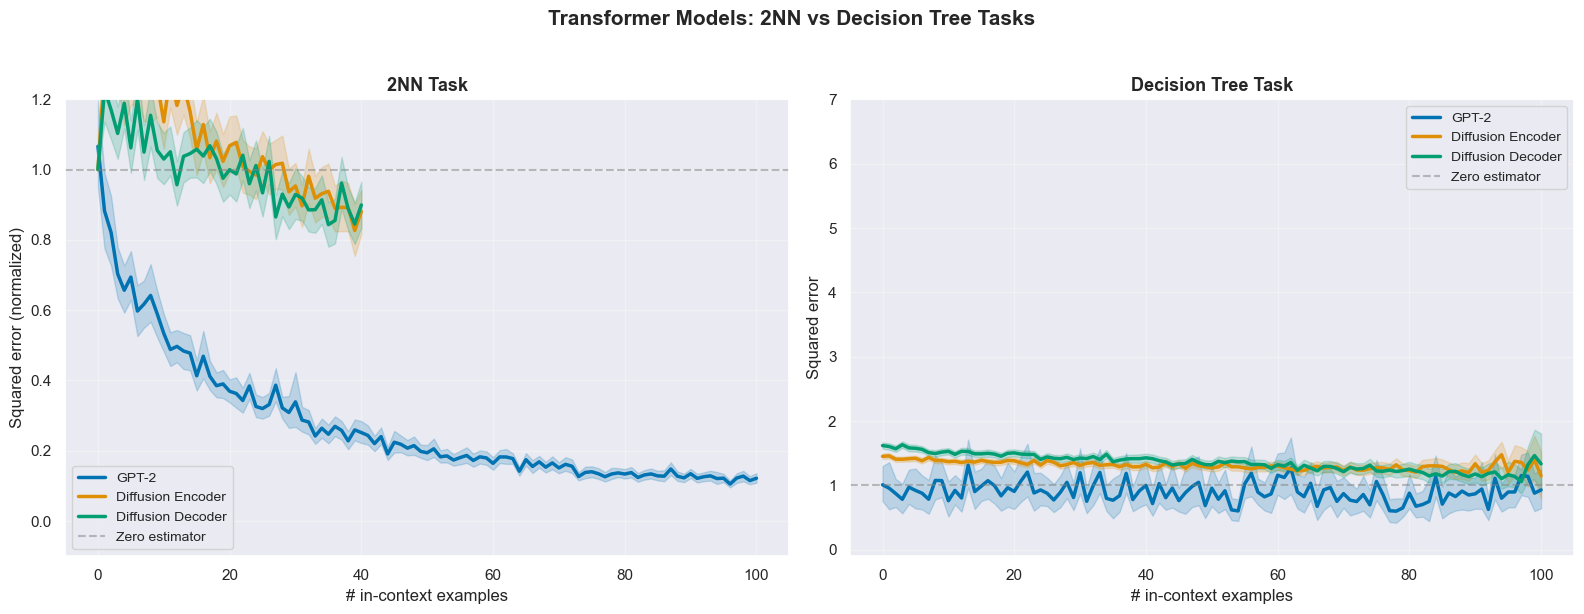


✓ Side-by-side comparison plot saved


In [27]:
# Create side-by-side comparison for transformer models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
colors = sns.color_palette('colorblind')

# Get transformer models
transformer_names = [
    'gpt2_embd=256_layer=12_head=8',
    'diffusion_encoder_embd=256_layer=12_head=8_timesteps=100',
    'diffusion_decoder_embd=256_layer=12_head=8_timesteps=100'
]

# Plot 2NN task
normalization_2nn = TASK_NORMALIZATION['relu_2nn_regression']
if "standard" in nn_metrics:
    for idx, model_name in enumerate(transformer_names):
        if model_name in nn_metrics["standard"]:
            metrics = nn_metrics["standard"][model_name]
            
            # Apply uniform normalization
            means = np.array(metrics["mean"]) / normalization_2nn
            low = np.array(metrics["bootstrap_low"]) / normalization_2nn
            high = np.array(metrics["bootstrap_high"]) / normalization_2nn
            
            label = get_model_label(model_name)
            ax1.plot(means, lw=2.5, label=label, color=colors[idx])
            ax1.fill_between(range(len(low)), low, high, alpha=0.2, color=colors[idx])
    
    ax1.axhline(1.0, ls="--", color="gray", alpha=0.5, label="Zero estimator")
    ax1.set_xlabel("# in-context examples", fontsize=12)
    ax1.set_ylabel("Squared error (normalized)", fontsize=12)
    ax1.set_title("2NN Task", fontsize=13, fontweight='bold')
    ax1.set_ylim(-0.1, 1.2)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)

# Plot Decision Tree task
normalization_dt = TASK_NORMALIZATION['decision_tree']
if "standard" in dt_metrics:
    for idx, model_name in enumerate(transformer_names):
        if model_name in dt_metrics["standard"]:
            metrics = dt_metrics["standard"][model_name]
            
            # Apply uniform normalization
            means = np.array(metrics["mean"]) / normalization_dt
            low = np.array(metrics["bootstrap_low"]) / normalization_dt
            high = np.array(metrics["bootstrap_high"]) / normalization_dt
            
            label = get_model_label(model_name)
            ax2.plot(means, lw=2.5, label=label, color=colors[idx])
            ax2.fill_between(range(len(low)), low, high, alpha=0.2, color=colors[idx])
    
    ax2.axhline(1.0, ls="--", color="gray", alpha=0.5, label="Zero estimator")
    ax2.set_xlabel("# in-context examples", fontsize=12)
    ax2.set_ylabel("Squared error", fontsize=12)
    ax2.set_title("Decision Tree Task", fontsize=13, fontweight='bold')
    ax2.set_ylim(-0.1, 7)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)

plt.suptitle("Transformer Models: 2NN vs Decision Tree Tasks", fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "side_by_side_comparison.pdf", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / "side_by_side_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Side-by-side comparison plot saved")

## 9. Final Summary Statistics

In [28]:
# Calculate and display key statistics
print("\n" + "="*80)
print("FINAL SUMMARY: TRANSFORMER MODELS PERFORMANCE")
print("="*80)

transformer_names = [
    'gpt2_embd=256_layer=12_head=8',
    'diffusion_encoder_embd=256_layer=12_head=8_timesteps=100',
    'diffusion_decoder_embd=256_layer=12_head=8_timesteps=100'
]

normalization_2nn = TASK_NORMALIZATION['relu_2nn_regression']
normalization_dt = TASK_NORMALIZATION['decision_tree']

for model_name in transformer_names:
    display_name = get_model_label(model_name)
    print(f"\n{display_name}:")
    print("-" * 80)
    
    # 2NN results
    if "standard" in nn_metrics and model_name in nn_metrics["standard"]:
        nn_std_final = nn_metrics["standard"][model_name]["mean"][-1]
        nn_std_initial = nn_metrics["standard"][model_name]["mean"][0]
        nn_std_improvement = (1 - nn_std_final / nn_std_initial) * 100
        nn_std_final_norm = nn_std_final / normalization_2nn
        
        print(f"  2NN (Standard):")
        print(f"    Final loss: {nn_std_final:.4f} (normalized: {nn_std_final_norm:.4f})")
        print(f"    Learning improvement: {nn_std_improvement:.1f}% (from first to last example)")
    
    if "linear_regression" in nn_metrics and model_name in nn_metrics["linear_regression"]:
        nn_lr_final = nn_metrics["linear_regression"][model_name]["mean"][-1]
        nn_lr_initial = nn_metrics["linear_regression"][model_name]["mean"][0]
        nn_lr_improvement = (1 - nn_lr_final / nn_lr_initial) * 100
        nn_lr_final_norm = nn_lr_final / normalization_2nn
        
        print(f"  2NN (Linear Regression):")
        print(f"    Final loss: {nn_lr_final:.4f} (normalized: {nn_lr_final_norm:.4f})")
        print(f"    Learning improvement: {nn_lr_improvement:.1f}%")
    
    # Decision Tree results
    if "standard" in dt_metrics and model_name in dt_metrics["standard"]:
        dt_std_final = dt_metrics["standard"][model_name]["mean"][-1]
        dt_std_initial = dt_metrics["standard"][model_name]["mean"][0]
        dt_std_improvement = (1 - dt_std_final / dt_std_initial) * 100
        dt_std_final_norm = dt_std_final / normalization_dt
        
        print(f"  Decision Tree (Standard):")
        print(f"    Final loss: {dt_std_final:.4f} (normalized: {dt_std_final_norm:.4f})")
        print(f"    Learning improvement: {dt_std_improvement:.1f}%")

print("\n" + "="*80)
print(f"Note: 2NN normalized by {normalization_2nn}, Decision Tree by {normalization_dt}")
print("✓ All visualizations complete! Check the 'plots' directory for saved figures.")
print("="*80)


FINAL SUMMARY: TRANSFORMER MODELS PERFORMANCE

GPT-2:
--------------------------------------------------------------------------------
  2NN (Standard):
    Final loss: 2.4339 (normalized: 0.1217)
    Learning improvement: 88.6% (from first to last example)
  2NN (Linear Regression):
    Final loss: 0.8046 (normalized: 0.0402)
    Learning improvement: 96.2%
  Decision Tree (Standard):
    Final loss: 0.9302 (normalized: 0.9302)
    Learning improvement: 7.9%

Diffusion Encoder:
--------------------------------------------------------------------------------
  2NN (Standard):
    Final loss: 17.6165 (normalized: 0.8808)
    Learning improvement: 11.9% (from first to last example)
  2NN (Linear Regression):
    Final loss: 3.0337 (normalized: 0.1517)
    Learning improvement: 84.8%
  Decision Tree (Standard):
    Final loss: 1.1492 (normalized: 1.1492)
    Learning improvement: 20.8%

Diffusion Decoder:
--------------------------------------------------------------------------------
  